# Whatever

For reference, dimensions of the data:
```python
    # Create a vector of node features including index, type, Vm, Va, Pd, Qd, Gs, Bs
    case['bus'] = x[0]['bus']
    node_features_y = np.zeros((case['bus'].shape[0], 8))
    node_features_y[:, 0] = case['bus'][:, 0]  # index
    node_features_y[:, 1] = case['bus'][:, 1]  # type
    # Vm ----This changes for Load Buses
    node_features_y[:, 2] = case['bus'][:, 7]
    # Va ----This changes for every bus excecpt slack bus
    node_features_y[:, 3] = case['bus'][:, 8]
    node_features_y[:, 4] = case['bus'][:, 2]  # Pd
    node_features_y[:, 5] = case['bus'][:, 3]  # Qd
    node_features_y[:, 6] = case['bus'][:, 4]  # Gs
    node_features_y[:, 7] = case['bus'][:, 5]  # Bs
```

## Load Modules

In [40]:
import os

import torch
import torch_geometric
import matplotlib.pyplot as plt

from datasets.PowerFlowData import PowerFlowData
from networks.MPN import MPN
from utils.evaluation import load_model

LOG_DIR = 'logs'
SAVE_DIR = 'models'

os.makedirs(LOG_DIR+'/results', exist_ok=True)


In [29]:
feature_names = [
    'index',                # -
    'type',                 # -
    'voltage magnitude',    # --- we care about this
    'voltage angle',        # --- we care about this
    'active power',         # --- we care about this
    'reactive power',       # --- we care about this
    'Gs',                   # -
    'Bs'                    # -
]

## Visualize results
Load saved model and prepare data. Select only 100 samples for simplicity.

In [24]:
run_id = '20230606-1194'
num_samples = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
testset = PowerFlowData(root='data', case='14', split=[.5, .2, .3], task='test')
testloader = torch_geometric.loader.DataLoader(testset, batch_size=1, shuffle=False)

node_in_dim, node_out_dim, edge_dim = testset.get_data_dimensions()
model = MPN(
    nfeature_dim=node_in_dim, 
    efeature_dim=edge_dim, 
    output_dim=node_out_dim, 
    hidden_dim=64, 
    n_gnn_layers=3, 
    K=3, 
    dropout_rate=0.5
).to(device) # 40k params

model, _ = load_model(model, run_id, device)

preds = []
targets = []
with torch.no_grad():
    for i, sample in enumerate(testloader):
        if i == num_samples:
            break
        sample = sample.to(device)
        pred = model(sample)
        preds.append(pred)
        targets.append(sample.y)

preds = torch.stack(preds, dim=0).cpu()
targets = torch.stack(targets, dim=0).cpu()
error = preds - targets

### Error for all scenarios for one node

In [25]:
node_ID = 2
error_node = error[:, node_ID, :]
scenarios = torch.arange(len(error_node))
target_node = targets[:, node_ID, :]
pred_node = preds[:, node_ID, :]

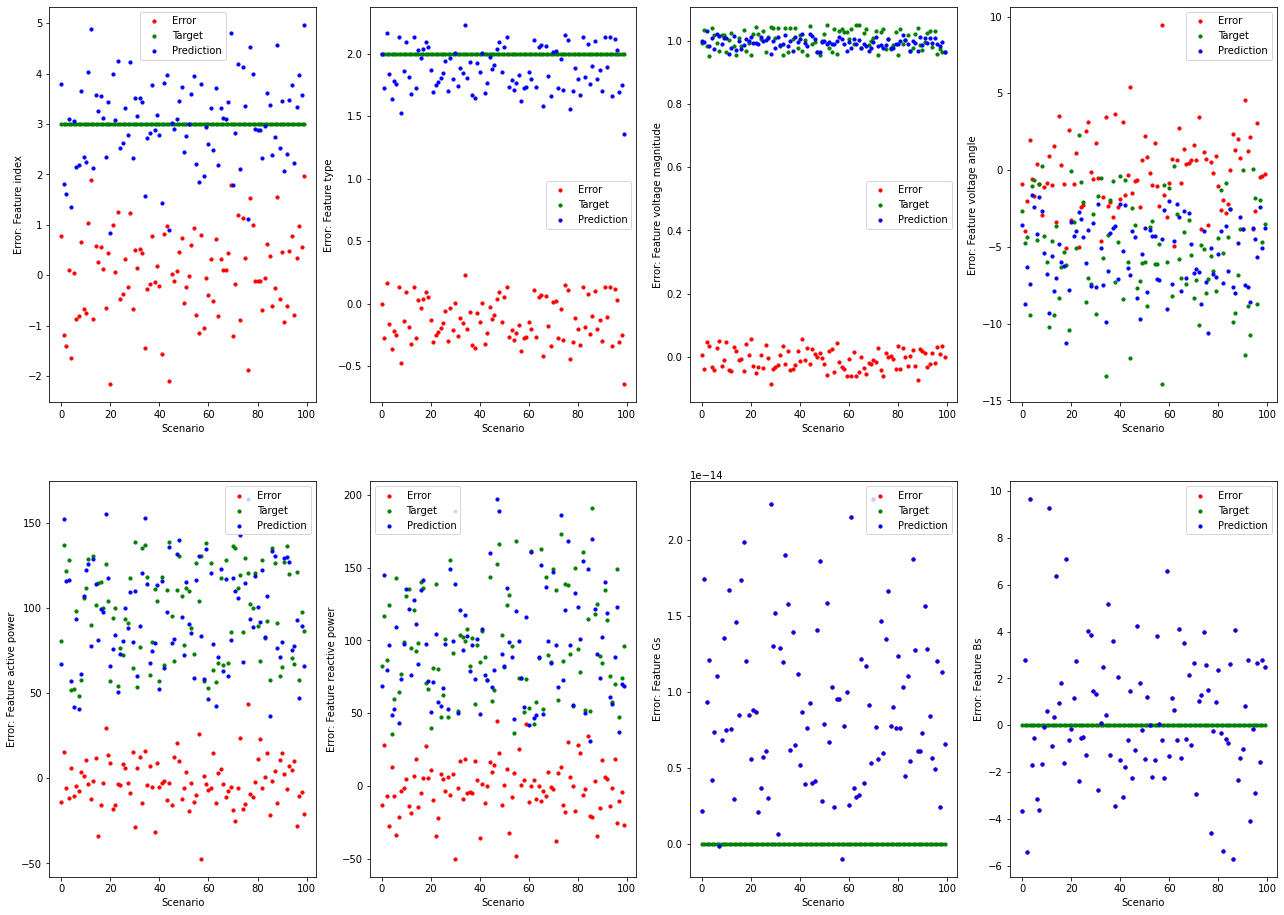

In [41]:
indices = torch.arange(len(error_node))

fig, axes = plt.subplots(2, 4, figsize=(22, 16))
for idx, ax in enumerate(axes.flatten()):
    ax.scatter(scenarios, error_node[indices, idx], c='red', label='Error', s=10)
    ax.scatter(scenarios, target_node[indices, idx], c='green', label='Target', s=10)
    ax.scatter(scenarios, pred_node[indices, idx], c='blue', label='Prediction', s=10)
    ax.set_xlabel('Scenario')
    ax.set_ylabel(f'Error: Feature {feature_names[idx]}')
    ax.legend()
    
plt.savefig(LOG_DIR+'/results/'+'error_all_scenarios_'+run_id+'.png')
plt.show()

### Error for all nodes in one scenario

In [43]:
scenario_id = 7
error_scenario = error[scenario_id, :, :]
nodes = torch.arange(len(error_scenario))
target_scenario = targets[scenario_id, :, :]
pred_scenario = preds[scenario_id, :, :]

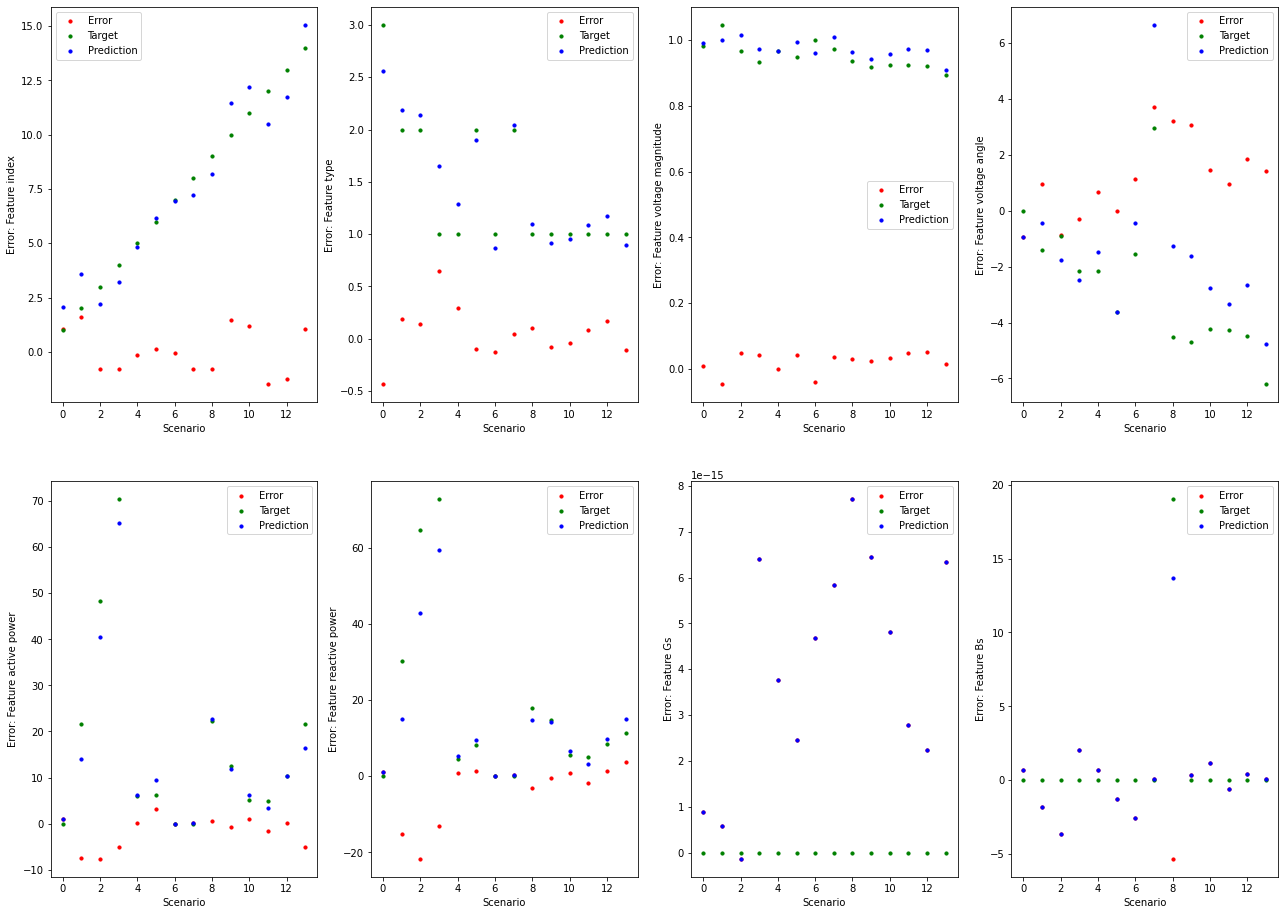

In [44]:
indices = torch.arange(len(error_scenario))

fig, axes = plt.subplots(2, 4, figsize=(22, 16))
for idx, ax in enumerate(axes.flatten()):
    ax.scatter(nodes, error_scenario[indices, idx], c='red', label='Error', s=10)
    ax.scatter(nodes, target_scenario[indices, idx], c='green', label='Target', s=10)
    ax.scatter(nodes, pred_scenario[indices, idx], c='blue', label='Prediction', s=10)
    ax.set_xlabel('Scenario')
    ax.set_ylabel(f'Error: Feature {feature_names[idx]}')
    ax.legend()
    
plt.savefig(LOG_DIR+'/results/'+'error_all_nodes_'+run_id+'.png')
plt.show()